In [1]:
import os, sys
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.interpolate import make_interp_spline

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from forecasting.get_forecasting_model import *

In [2]:
processed_dir = os.path.join(project_root, "data", "processed")

# Load data
df = pd.read_csv(os.path.join(processed_dir, "train.csv"))
viz = pd.read_csv(os.path.join(processed_dir, "for_visualization.csv"))

# df = pd.read_csv('D:/Study/Education/Projects/DataFlow/DataFlow_2026/data/processed/train.csv')
# viz = pd.read_csv('D:/Study/Education/Projects/DataFlow/DataFlow_2026/data/processed/for_visualization.csv')

df['time'] = pd.to_datetime(df['time'])
viz['time'] = pd.to_datetime(viz['time'])

df['status'] = df['status'].astype(str)

In [3]:
predictor5 = Predictor('rvfl', '5min')
predictor1 = Predictor('rvfl', '1min')
predictor15 = Predictor('rvfl', '15min')
predictor60 = Predictor('rvfl', '60min')


df_agg_5 = predictor5.agg_df(df)
df_agg_1 = predictor1.agg_df(df)
df_agg_15 = predictor15.agg_df(df)
df_agg_60 = predictor60.agg_df(df)

In [17]:
df.head(1)

,ip,identd,user,time,request,status,size,resource,protocol,utc,status_label
0,199.72.81.55,-,-,1995-07-01 00:00:01,GET /history/apollo/ HTTP/1.0,200,6245.0,/history/apollo/,HTTP/1.0,UTC - 04,Success


In [18]:
df_agg.head(1)

,time,size,Error,No Change,Not Found,Redirected,Success,anomaly,log_time
0,1995-07-01,5277675.0,0.0,19.0,1.0,14.0,267.0,False,15.478996


### 1. Overall

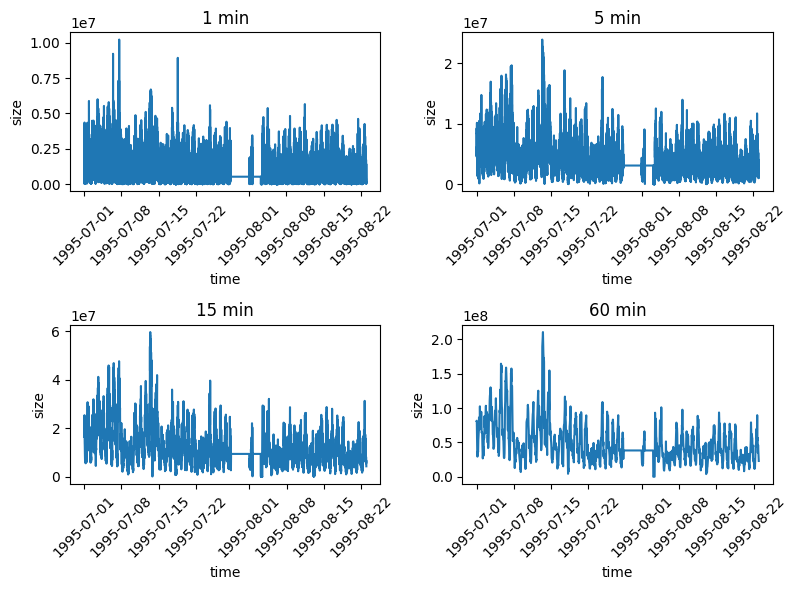

In [9]:
plt.figure(figsize = (8,6))

plt.subplot(2,2,1)
sns.lineplot(data=df_agg_1, x='time', y='size')
plt.title('1 min')
plt.xticks(rotation = 45)

plt.subplot(2,2,2)
sns.lineplot(data=df_agg_5, x='time', y='size')
plt.title('5 min')
plt.xticks(rotation = 45)

plt.subplot(2,2,3)
sns.lineplot(data=df_agg_15, x='time', y='size')
plt.title('15 min')
plt.xticks(rotation = 45)

plt.subplot(2,2,4)
sns.lineplot(data=df_agg_60, x='time', y='size')
plt.title('60 min')
plt.xticks(rotation = 45)

plt.tight_layout()
plt.show()

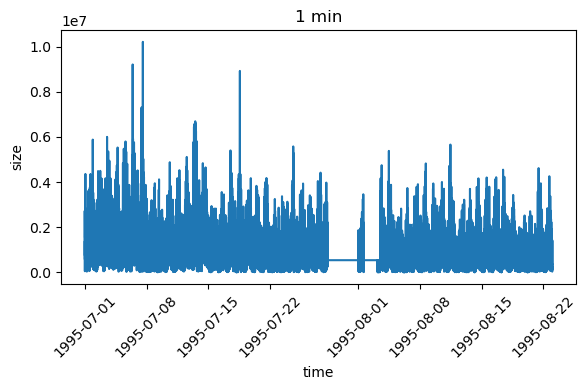

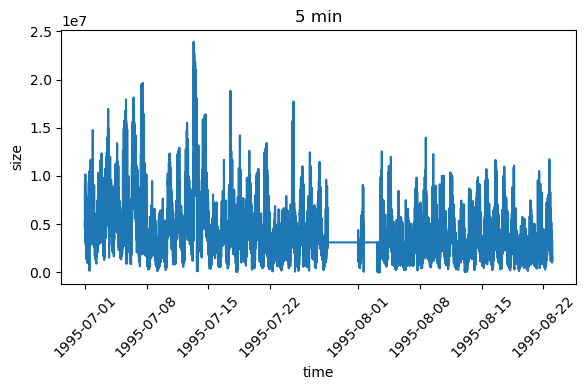

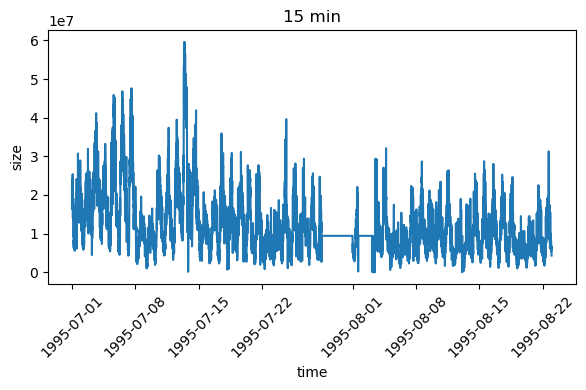

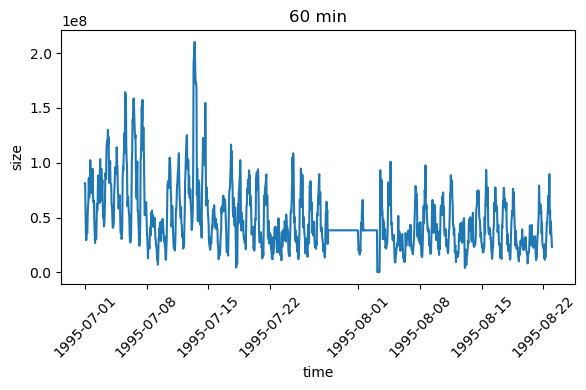

In [5]:
plots = {
    "1 min": df_agg_1,
    "5 min": df_agg_5,
    "15 min": df_agg_15,
    "60 min": df_agg_60,
}

for title, df in plots.items():
    plt.figure(figsize=(6, 4))
    sns.lineplot(data=df, x='time', y='size')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"size_over_time_{title.replace(' ', '_')}.png", dpi=300)
    plt.show()


In [ ]:
def resample_and_spike(df, freq, threshold=3):
    """
    Resamples hits by sum and error_rate by mean.
    Recalculates spikes using Z-Score of the new aggregated hits.
    """
    resampled = df.set_index('time').resample(freq).agg({
        'hits_per_sec': 'sum',
        'error_rate': 'mean'
    }).reset_index()
    
    resampled['z_score'] = stats.zscore(resampled['hits_per_sec'])
    resampled['is_spike'] = resampled['z_score'].abs() > threshold
    
    return resampled

viz_1m = resample_and_spike(viz, '1min')
viz_5m = resample_and_spike(viz, '5min')
viz_15m = resample_and_spike(viz, '15min')

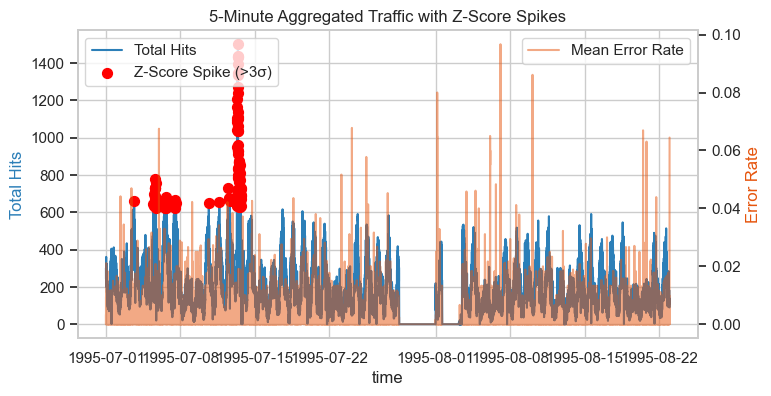

In [27]:
def plot_resampled_viz(df, title="Traffic Analysis"):
    plt.figure(figsize=(8, 4))
    ax1 = plt.gca()
    
    # Hits (Sum)
    sns.lineplot(data=df, x='time', y='hits_per_sec', ax=ax1, color='#2c7fb8', label='Total Hits')
    ax1.set_ylabel('Total Hits', color='#2c7fb8', fontsize=12)
    
    # Error Rate (Mean)
    ax2 = ax1.twinx()
    sns.lineplot(data=df, x='time', y='error_rate', ax=ax2, color='#e6550d', label='Mean Error Rate', alpha=0.5)
    ax2.set_ylabel('Error Rate', color='#e6550d', fontsize=12)
    ax2.grid(False)
    
    # Z-Score Spikes
    spikes = df[df['is_spike']]
    if not spikes.empty:
        ax1.scatter(spikes['time'], spikes['hits_per_sec'], color='red', s=50, zorder=5, label='Z-Score Spike (>3σ)')
    
    plt.title(title)
    ax1.legend(loc='upper left')
    plt.show()

plot_resampled_viz(viz_5m, "5-Minute Aggregated Traffic with Z-Score Spikes")

### Detailed

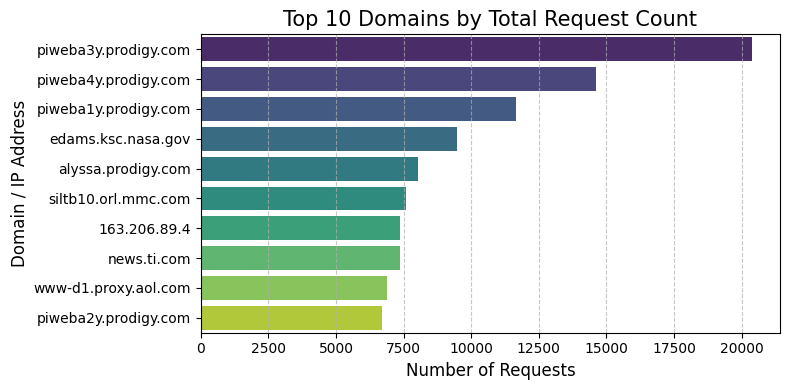

In [35]:
top_domains = df['ip'].value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    x=top_domains.values, 
    y=top_domains.index, 
    palette='viridis',
    hue=top_domains.index,
    legend=False
)

plt.title('Top 10 Domains by Total Request Count', fontsize=15)
plt.xlabel('Number of Requests', fontsize=12)
plt.ylabel('Domain / IP Address', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

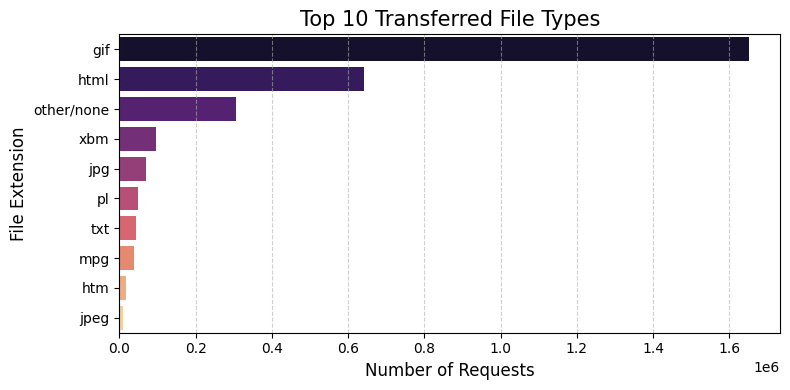

In [36]:
df['file_type'] = df['resource'].str.extract(r'\.([a-z0-9]{2,4})$', expand=False).str.lower()

top_file_types = df['file_type'].fillna('other/none').value_counts().head(10)

plt.figure(figsize=(8,4))
sns.barplot(
    x=top_file_types.values, 
    y=top_file_types.index, 
    palette='magma',
    hue=top_file_types.index,
    legend=False
)

plt.title('Top 10 Transferred File Types', fontsize=15)
plt.xlabel('Number of Requests', fontsize=12)
plt.ylabel('File Extension', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

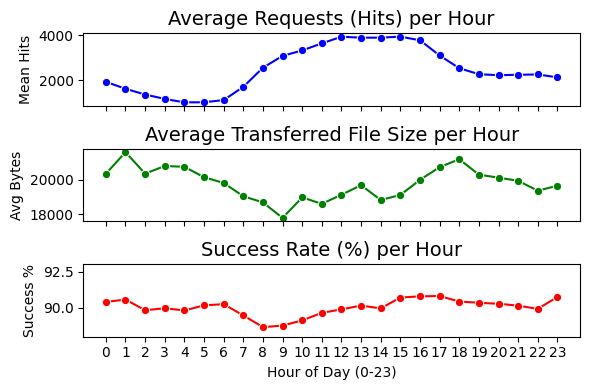

In [43]:
df['hour'] = df['time'].dt.hour
num_days = df['time'].dt.date.nunique()

daily_metrics = df.groupby('hour').agg(
    total_hits=('time', 'count'),
    mean_file_size=('size', 'mean'),
    success_count=('status_label', lambda x: (x == 'Success').sum())
).reset_index()

daily_metrics['mean_hits'] = daily_metrics['total_hits'] / num_days
daily_metrics['success_rate_%'] = (daily_metrics['success_count'] / daily_metrics['total_hits']) * 100

fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=True)

sns.lineplot(data=daily_metrics, x='hour', y='mean_hits', ax=axes[0], marker='o', color='blue')
axes[0].set_title('Average Requests (Hits) per Hour', fontsize=14)
axes[0].set_ylabel('Mean Hits')

sns.lineplot(data=daily_metrics, x='hour', y='mean_file_size', ax=axes[1], marker='o', color='green')
axes[1].set_title('Average Transferred File Size per Hour', fontsize=14)
axes[1].set_ylabel('Avg Bytes')

sns.lineplot(data=daily_metrics, x='hour', y='success_rate_%', ax=axes[2], marker='o', color='red')
axes[2].set_title('Success Rate (%) per Hour', fontsize=14)
axes[2].set_ylabel('Success %')
axes[2].set_ylim(88, 93) # Success is usually high, zoom in to see fluctuations

plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0-23)')
plt.tight_layout()
plt.show()

### Hypothesis

#### 1. Traffic follows a cycle with pattern

already Up, follows a pattern low in 0->7h, peak at 9-17h

#### 2. High traffic IP occurs at specific time in a day/ month

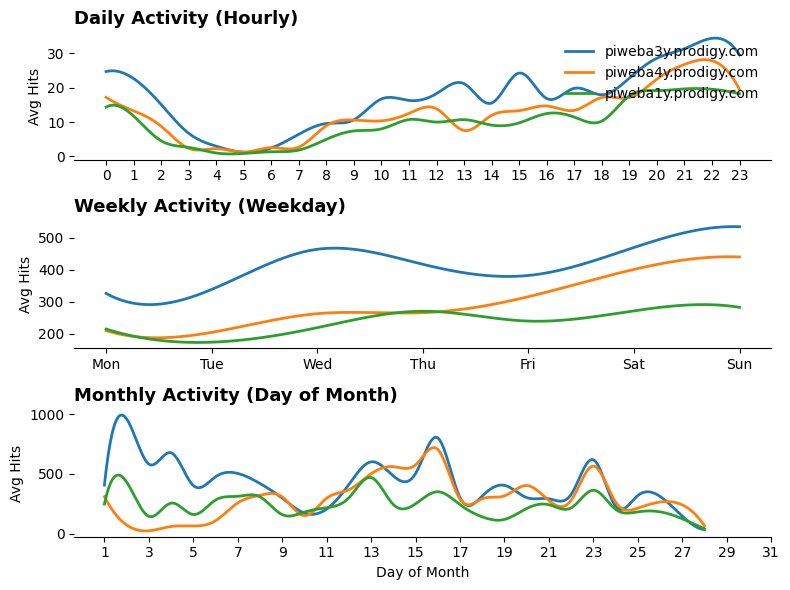

In [54]:
top_3_ips = df['ip'].value_counts().head(3).index
df_top_3 = df[df['ip'].isin(top_3_ips)]
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_month'] = df['time'].dt.day

unique_dates = pd.to_datetime(df['time'].dt.date.unique())
num_days = len(unique_dates)
days_counts = unique_dates.dayofweek.value_counts()
dom_counts = unique_dates.day.value_counts()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

def plot_smooth(ax, x, y, label=None):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_new)
    ax.plot(x_new, np.maximum(y_smooth, 0), label=label, linewidth=2)

ip_h = df_top_3.groupby(['ip', 'hour']).size().unstack(fill_value=0) / num_days
for ip in top_3_ips:
    plot_smooth(ax1, ip_h.columns.values, ip_h.loc[ip], label=ip)

ip_d = df_top_3.groupby(['ip', 'day_of_week']).size().unstack(fill_value=0).div(days_counts, axis=1)
for ip in top_3_ips:
    plot_smooth(ax2, ip_d.columns.values, ip_d.loc[ip])

ip_m = df_top_3.groupby(['ip', 'day_of_month']).size().unstack(fill_value=0).div(dom_counts, axis=1)
for ip in top_3_ips:
    plot_smooth(ax3, ip_m.columns.values, ip_m.loc[ip])

titles = ['Daily Activity (Hourly)', 'Weekly Activity (Weekday)', 'Monthly Activity (Day of Month)']
for ax, t in zip([ax1, ax2, ax3], titles):
    ax.set_title(t, loc='left', fontweight='bold', fontsize=13)
    ax.set_ylabel('Avg Hits')
    ax.set_facecolor('white')
    ax.grid(False)
    for s in ['top','right','left']: ax.spines[s].set_visible(False)

ax1.set_xticks(range(24))
ax1.legend(frameon=False, loc='upper right')
ax2.set_xticks(range(7))
ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax3.set_xticks(range(1, 32, 2))
ax3.set_xlabel('Day of Month')

plt.tight_layout()
plt.show()

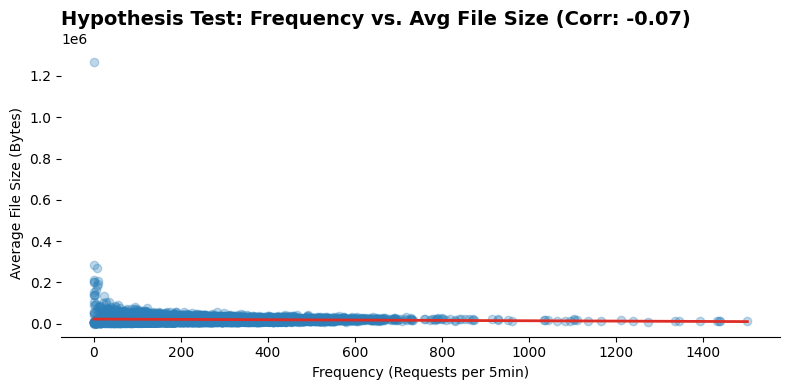

In [57]:
agg_relation = df.set_index('time').resample('5min').agg({
    'ip': 'count', 
    'size': 'mean'
}).rename(columns={'ip': 'frequency', 'size': 'avg_file_size'})

correlation = agg_relation.corr().iloc[0, 1]

plt.figure(figsize=(8, 4))
sns.regplot(
    data=agg_relation, 
    x='frequency', 
    y='avg_file_size', 
    scatter_kws={'alpha': 0.3, 'color': '#2c7fb8'}, 
    line_kws={'color': '#de2d26', 'linewidth': 2}
)

plt.title(f'Hypothesis Test: Frequency vs. Avg File Size (Corr: {correlation:.2f})', 
          loc='left', fontweight='bold', fontsize=14)
plt.xlabel('Frequency (Requests per 5min)')
plt.ylabel('Average File Size (Bytes)')

ax = plt.gca()
ax.set_facecolor('white')
ax.grid(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

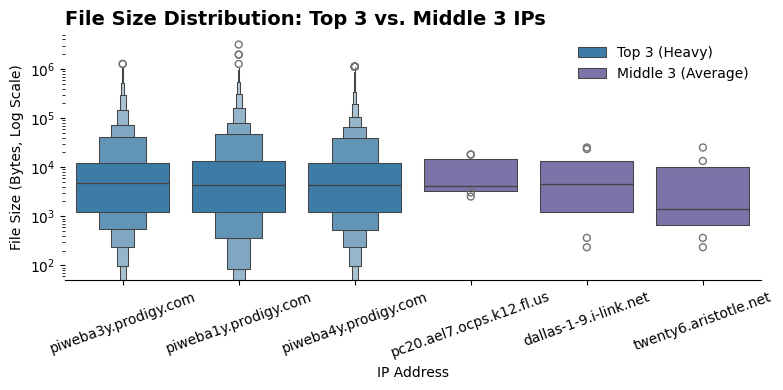

In [62]:
counts = df[df['size'] > 0]['ip'].value_counts()
mid_idx = len(counts) // 2

top_3 = counts.head(3).index.tolist()
middle_3 = counts.iloc[mid_idx-1 : mid_idx+2].index.tolist()

df_compare = df[df['ip'].isin(top_3 + middle_3)].copy()
df_compare['group'] = df_compare['ip'].apply(lambda x: 'Top 3 (Heavy)' if x in top_3 else 'Middle 3 (Average)')

plt.figure(figsize=(8, 4))
sns.boxenplot(
    data=df_compare, 
    x='ip', 
    y='size', 
    hue='group',
    palette={'Top 3 (Heavy)': '#2c7fb8', 'Middle 3 (Average)': '#756bb1'}
)

plt.yscale('log')
plt.title('File Size Distribution: Top 3 vs. Middle 3 IPs', loc='left', fontweight='bold', fontsize=14)
plt.ylabel('File Size (Bytes, Log Scale)')
plt.xlabel('IP Address')
plt.legend(frameon=False, title='')

ax = plt.gca()
ax.set_facecolor('white')
ax.grid(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()
